# Visualise Data on a Geographical Map to Identify Regions of Interest

In [1]:

# import libraries
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#for the gif
import os
import glob
import PIL
from PIL import Image, ImageEnhance, ImageOps
import imageio
import s3fs

In [2]:
from dotenv import load_dotenv
load_dotenv() 

True

## open the Zarr file

In [3]:
#insert the path you have saved the cube or go to tutorial Seasfire_datacube_tutorial.ipynb to see how to access it
#ds=xr.open_zarr(Path.home() / 'SeasFire.zarr')

fs = s3fs.S3FileSystem(
    anon=False,
    key=os.getenv("AWS_ACCESS_KEY_ID"),
    secret=os.getenv("AWS_SECRET_ACCESS_KEY"),
    client_kwargs={
        "region_name": os.getenv("AWS_REGION"),
        "endpoint_url": os.getenv("AWS_ENDPOINT_URL"),
    },
    default_fill_cache=False,
)

store = s3fs.S3Map(
    root="EarthCODE/OSCAssets/seasfire/seasfire_v0.4.zarr",
    s3=fs,
    check=False
)

In [4]:
%%time
ds = xr.open_zarr(store, consolidated=True)
ds

CPU times: user 1.33 s, sys: 242 ms, total: 1.57 s
Wall time: 3.52 s


<xarray.Dataset> Size: 164GB
Dimensions:                         (latitude: 720, longitude: 1440, time: 966)
Coordinates:
  * latitude                        (latitude) float64 6kB 89.88 ... -89.88
  * longitude                       (longitude) float64 12kB -179.9 ... 179.9
  * time                            (time) datetime64[ns] 8kB 2001-01-01 ... ...
Data variables: (12/59)
    area                            (latitude, longitude) float32 4MB dask.array<chunksize=(180, 360), meta=np.ndarray>
    biomes                          (latitude, longitude) float32 4MB dask.array<chunksize=(180, 360), meta=np.ndarray>
    cams_co2fire                    (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    cams_frpfire                    (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    drought_code_max                (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    drought_code_mean               (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ...                              ...
    t2m_max                         (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2m_mean                        (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2m_min                         (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    tp                              (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    vpd                             (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ws10                            (time, latitude, longitude) float32 4GB dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
Attributes:
    crs:          EPSG:4326
    description:  The SeasFire Cube is a scientific datacube for seasonal fir...
    title:        SeasFire Cube: A Global Dataset for Seasonal Fire Modeling ...

## We are making a gif in a loop with the total burned area (gwis_ba variable) for each year

## Similarly you can do the same for each variable you want

In [5]:
%%time
## in SeasFire Datacube v2.0 the burned area variables would have the water bodies masked with ERA-5 land sea mask 
# although while resampling and taking the sum nan values turn to 0. You can skip this by adding skipna=False in the sum but that there is a bug for that in the last year if data 2020
mask= ds['lsm'][:,:]

CPU times: user 792 μs, sys: 0 ns, total: 792 μs
Wall time: 822 μs


In [6]:
%%time
mask

CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 9.06 μs


<xarray.DataArray 'lsm' (latitude: 720, longitude: 1440)> Size: 4MB
dask.array<open_dataset-lsm, shape=(720, 1440), dtype=float32, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 6kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * longitude  (longitude) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
Attributes:
    long_name:  Land-sea mask
    provider:   ERA5
    units:      (0 - 1)

In [7]:
%%time
gwis=ds['gwis_ba']

CPU times: user 65 μs, sys: 11 μs, total: 76 μs
Wall time: 79.2 μs


CPU times: user 3 s, sys: 2.74 s, total: 5.74 s
Wall time: 3.61 s


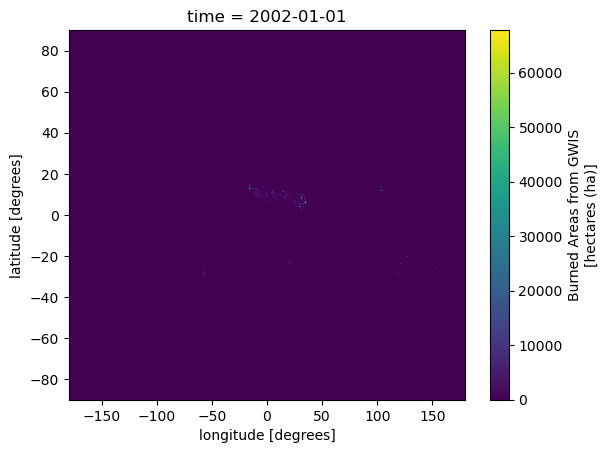

In [8]:
%%time
gwis[46,:,:].plot()

In [9]:
%%time
#resample to get yearly data 
gwis_all=gwis.resample(time="1Y").sum()

<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


CPU times: user 278 ms, sys: 1.25 ms, total: 280 ms
Wall time: 288 ms


In [10]:
%%time
gwis_all= gwis_all.where(mask>0.5)

CPU times: user 6.79 ms, sys: 4.01 ms, total: 10.8 ms
Wall time: 8.39 ms


CPU times: user 3.04 s, sys: 3.26 s, total: 6.3 s
Wall time: 2.77 s


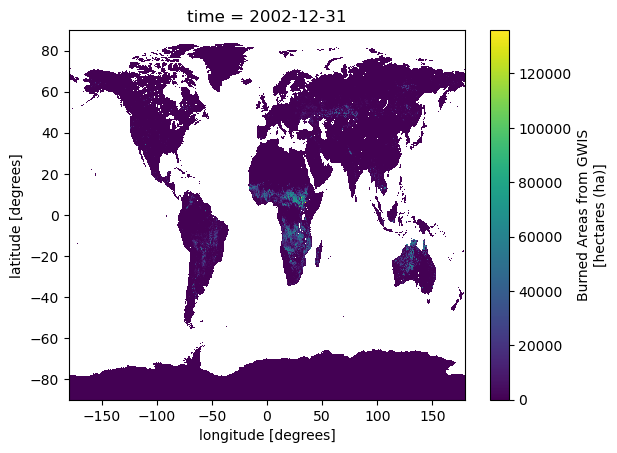

In [11]:
%%time
#check how it looks
gwis_all[1,:,:].plot()

## save the figures 

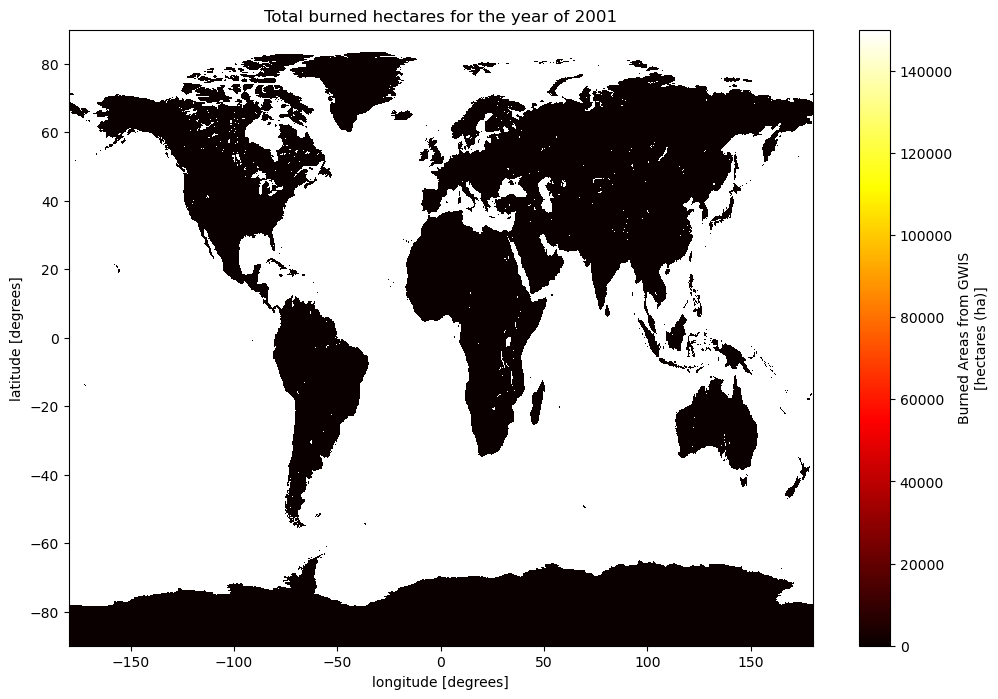

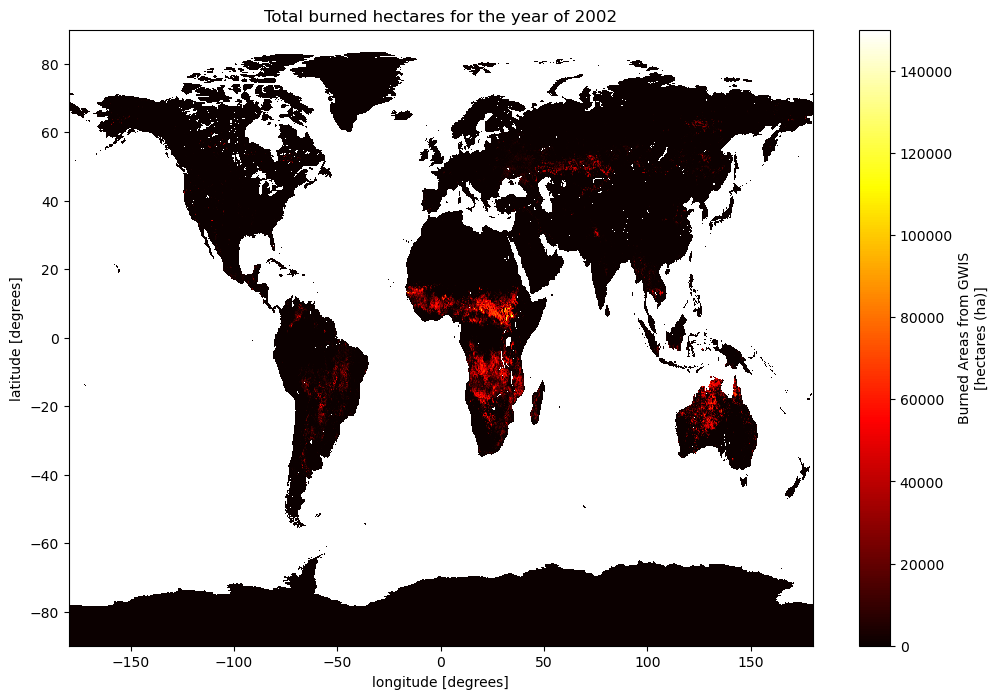

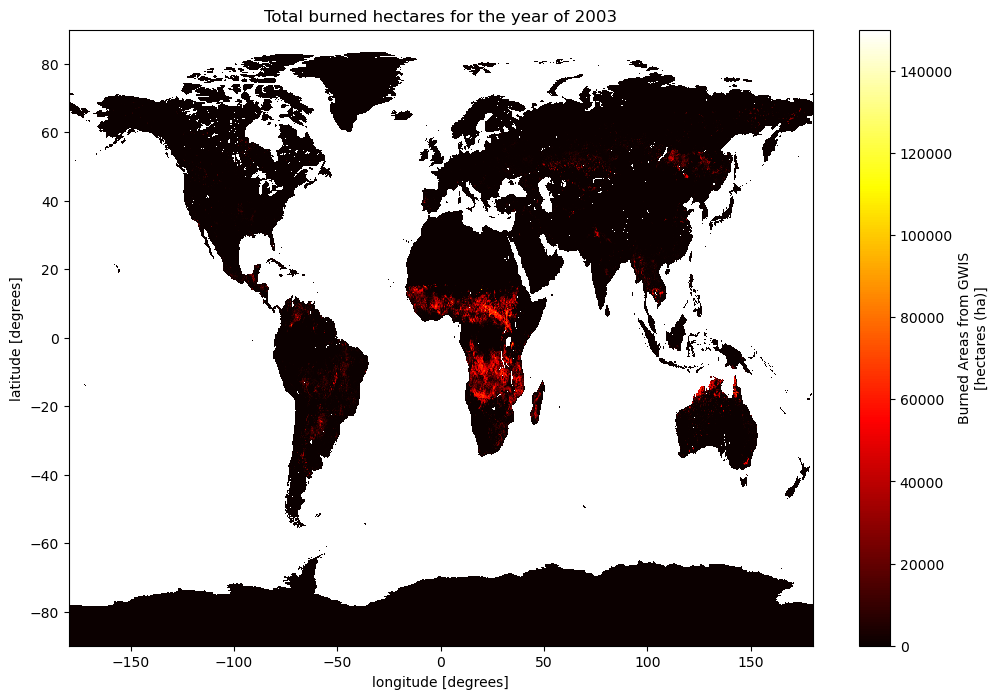

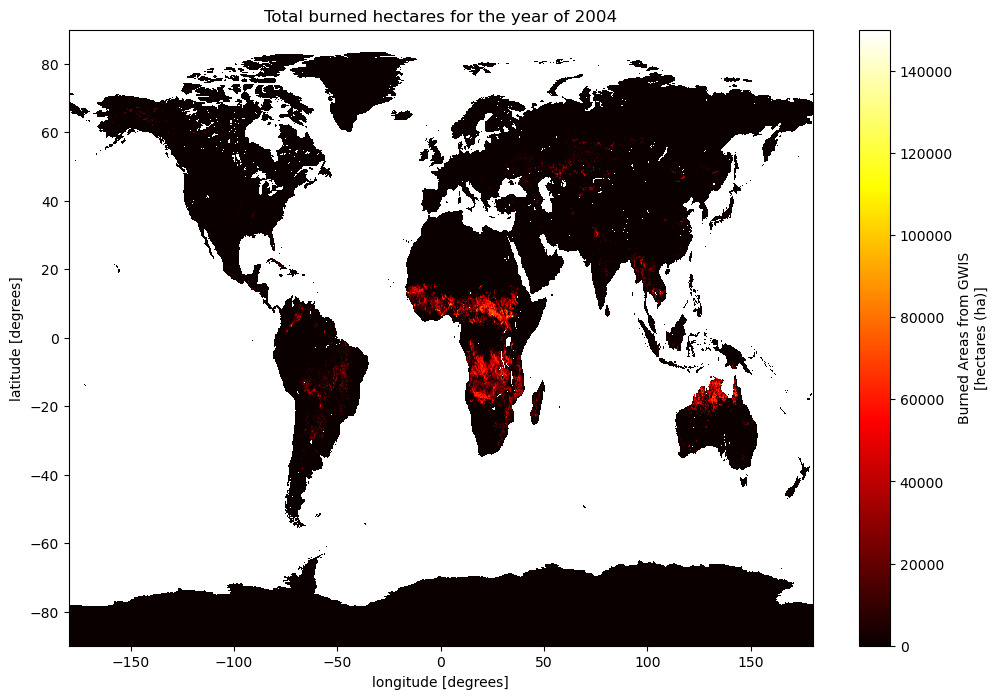

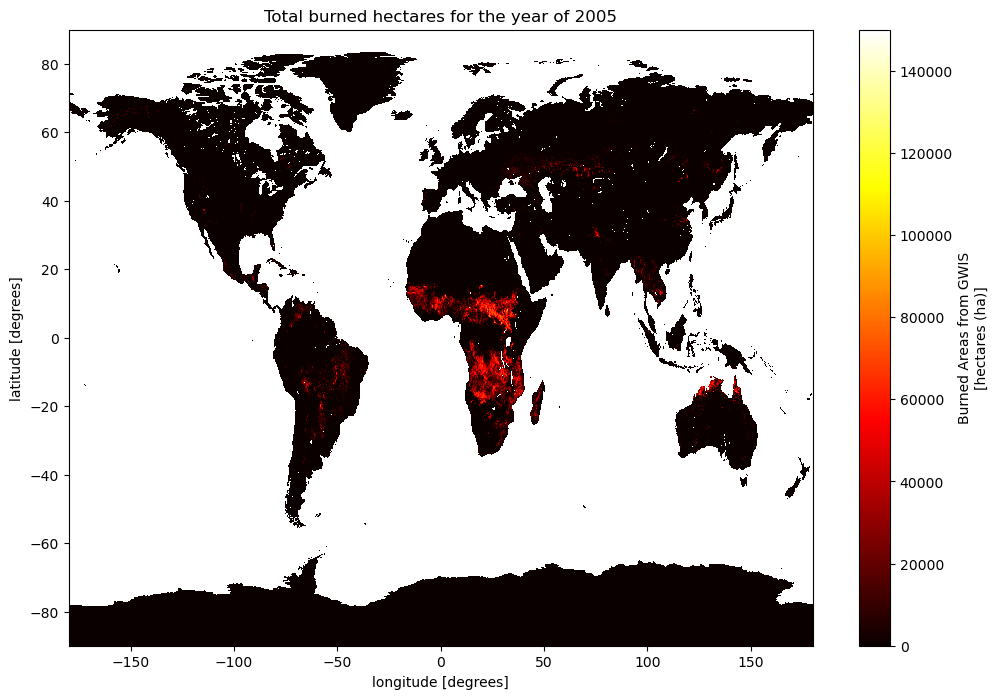

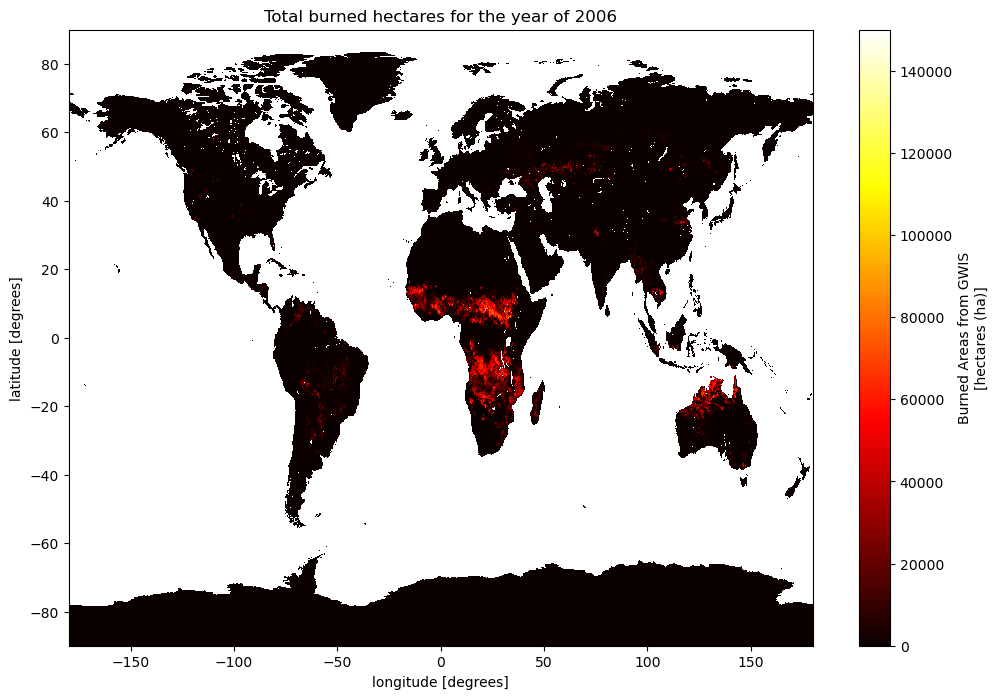

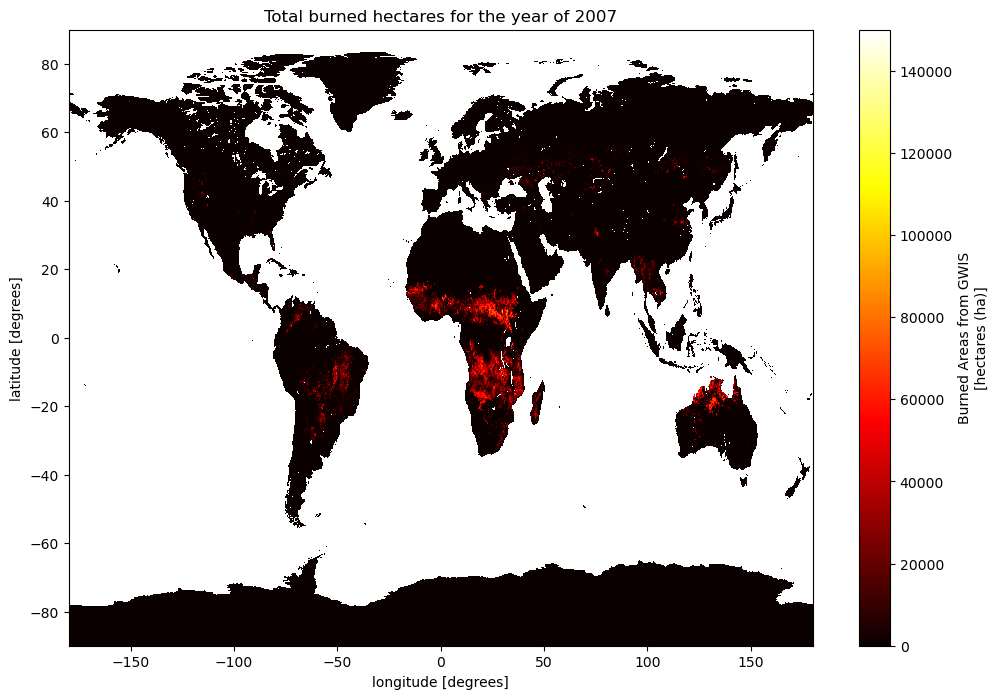

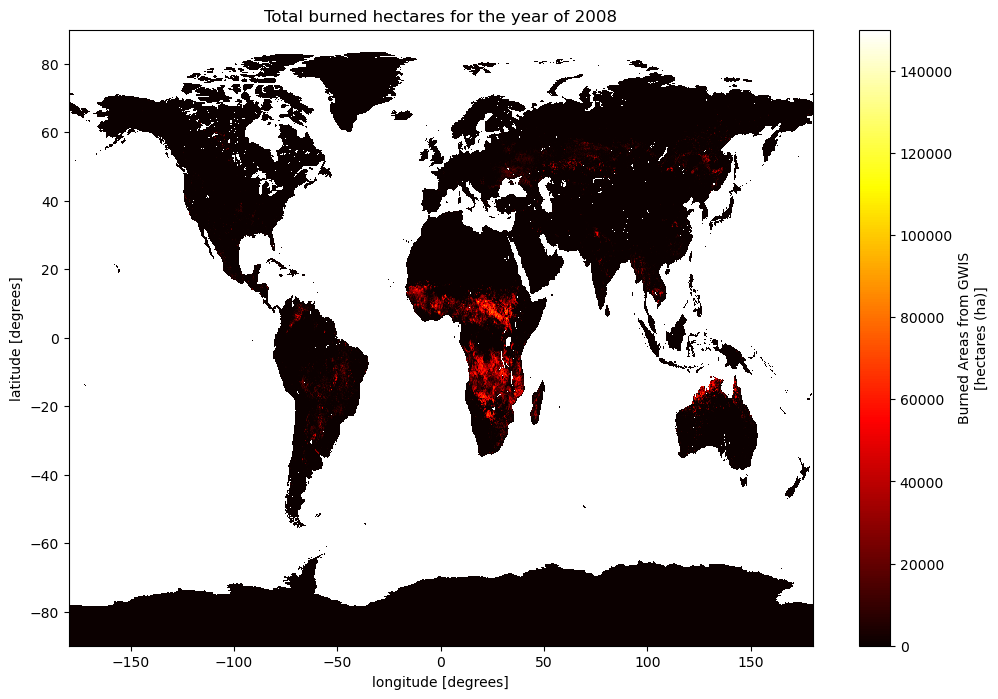

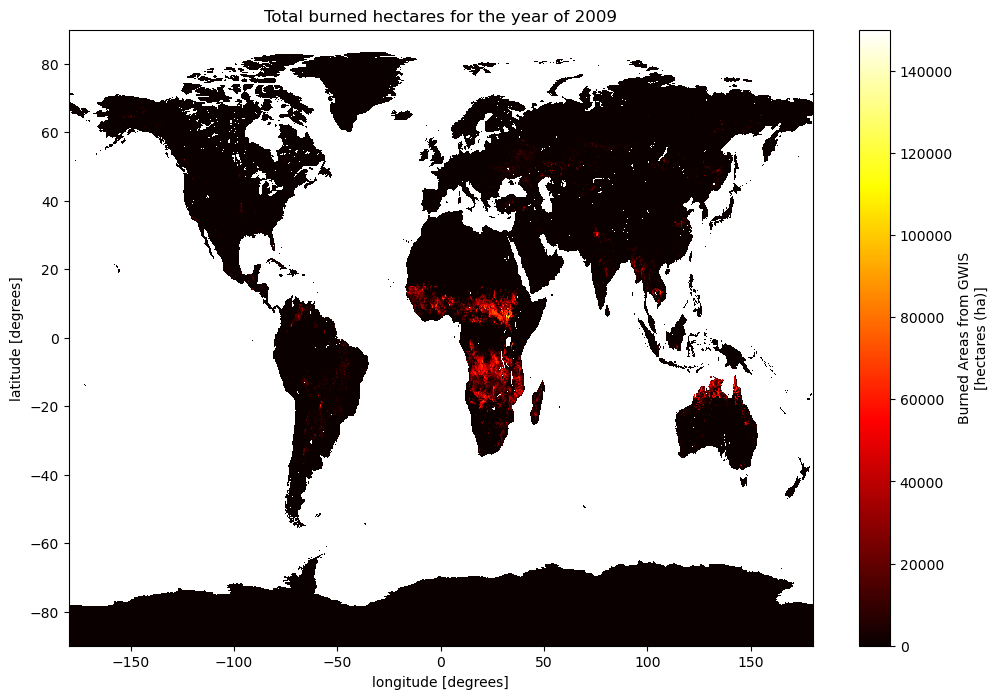

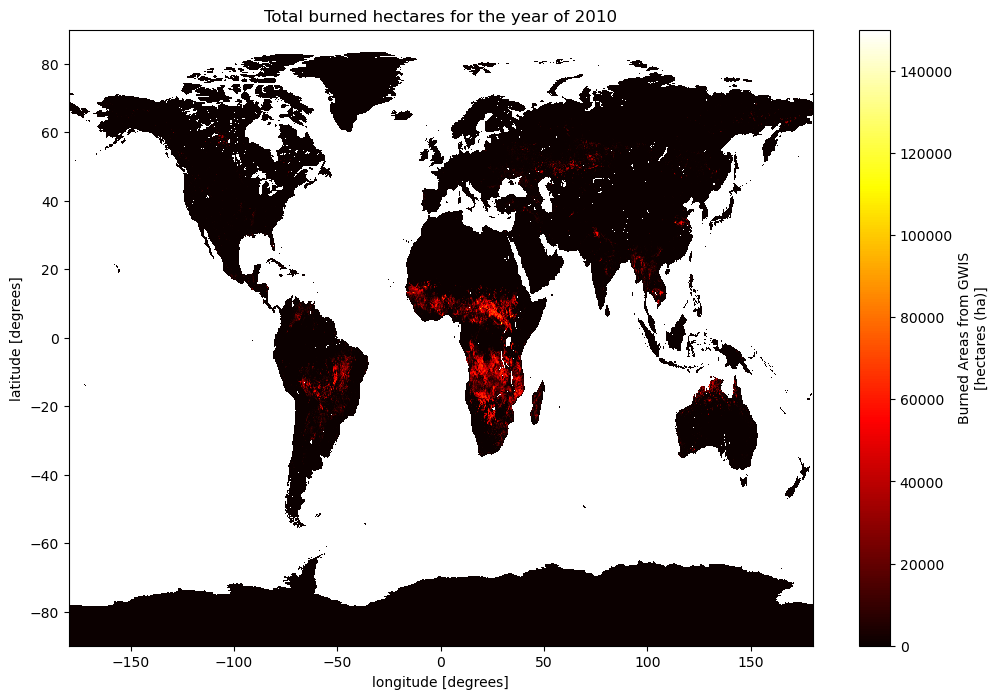

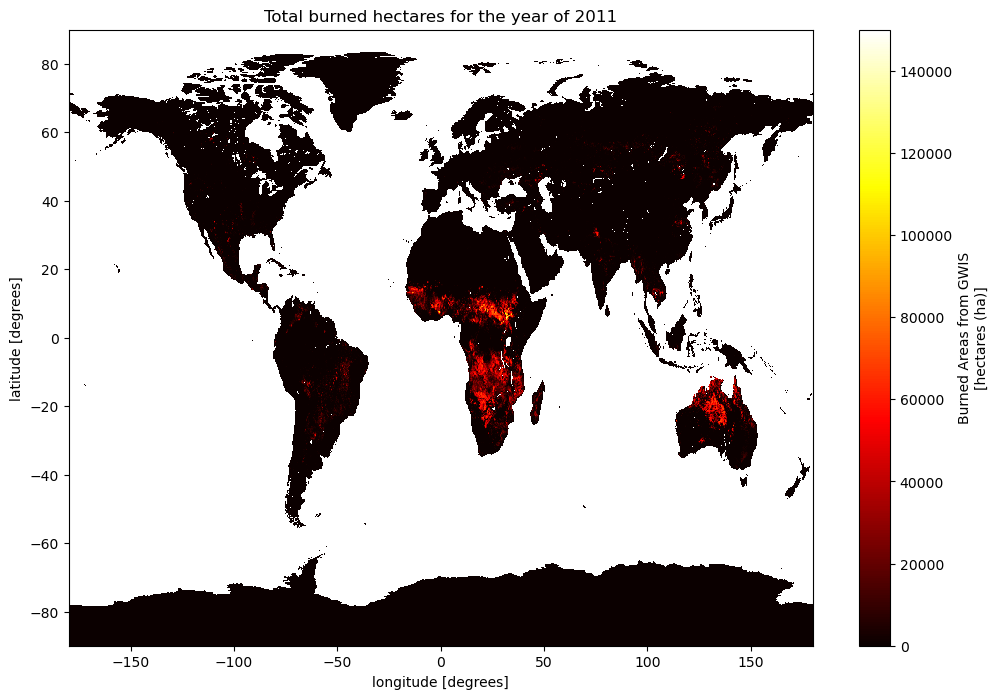

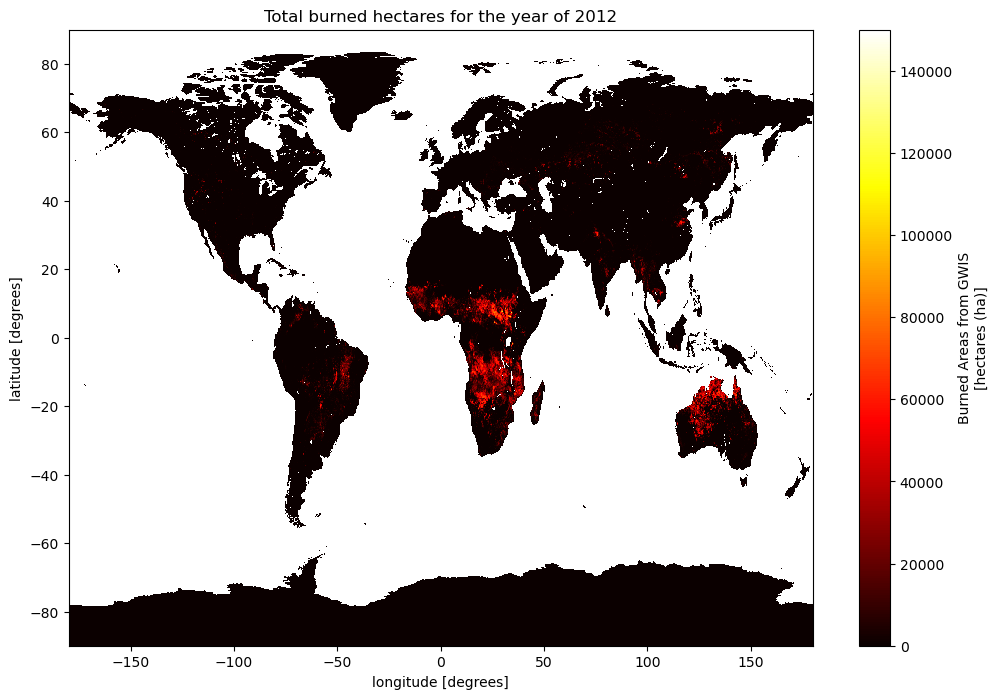

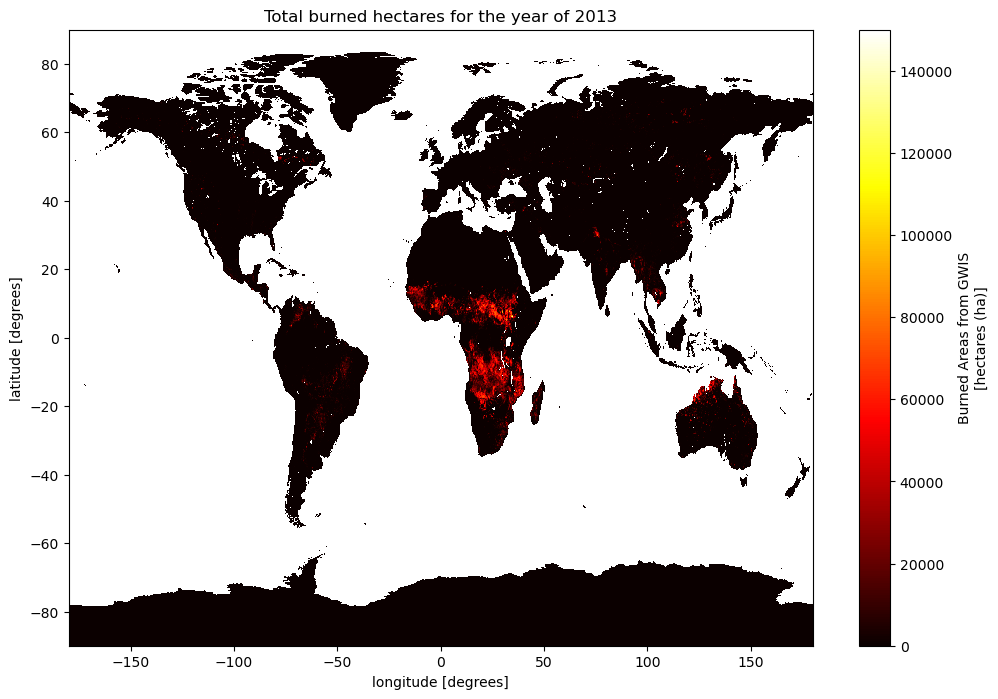

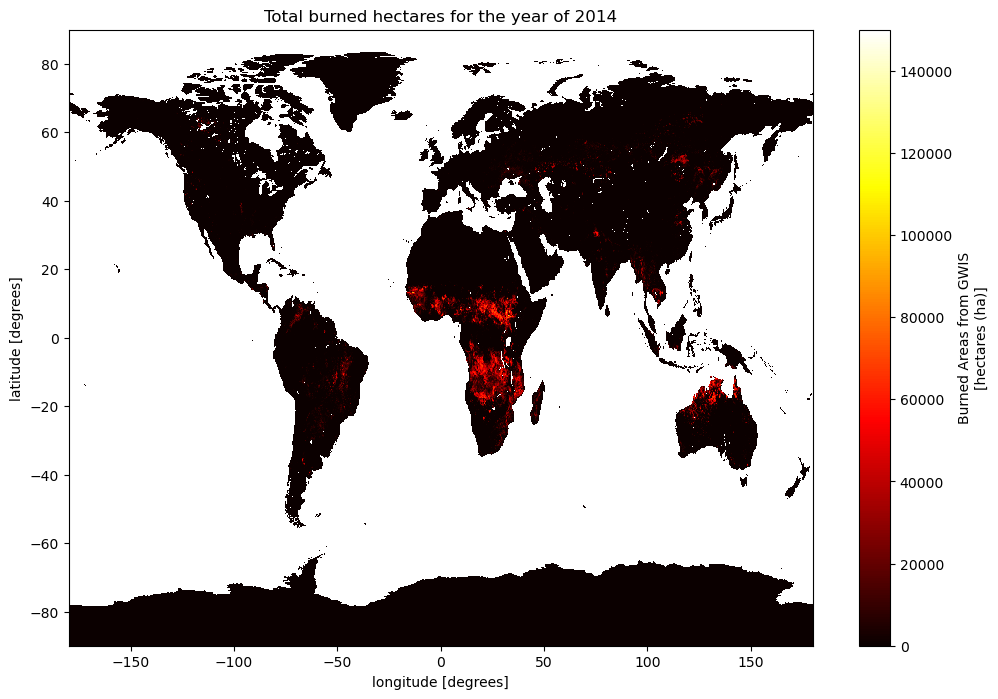

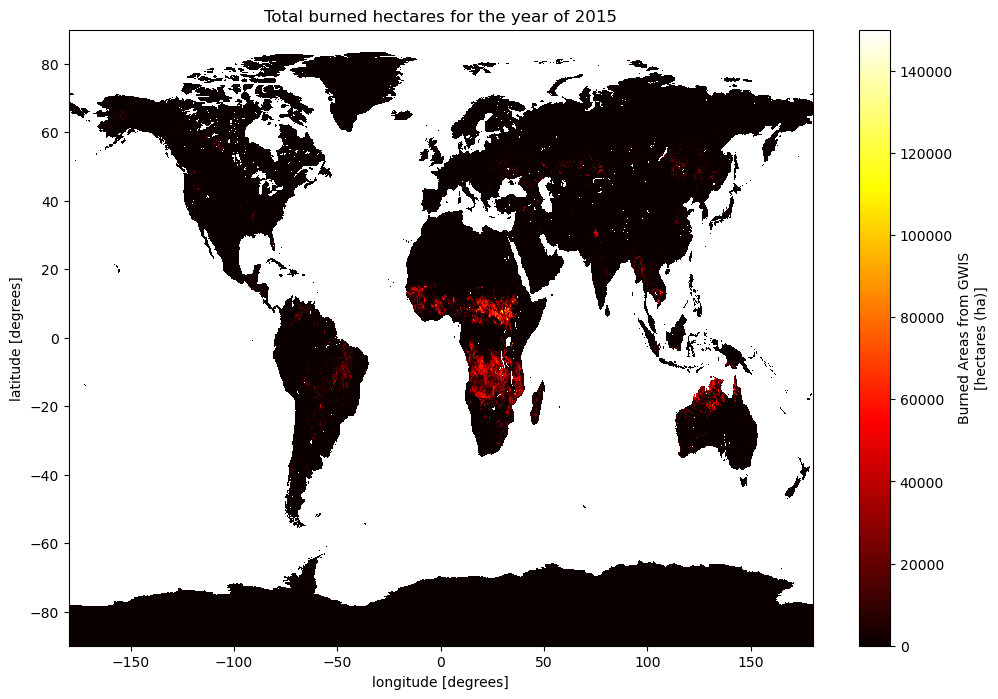

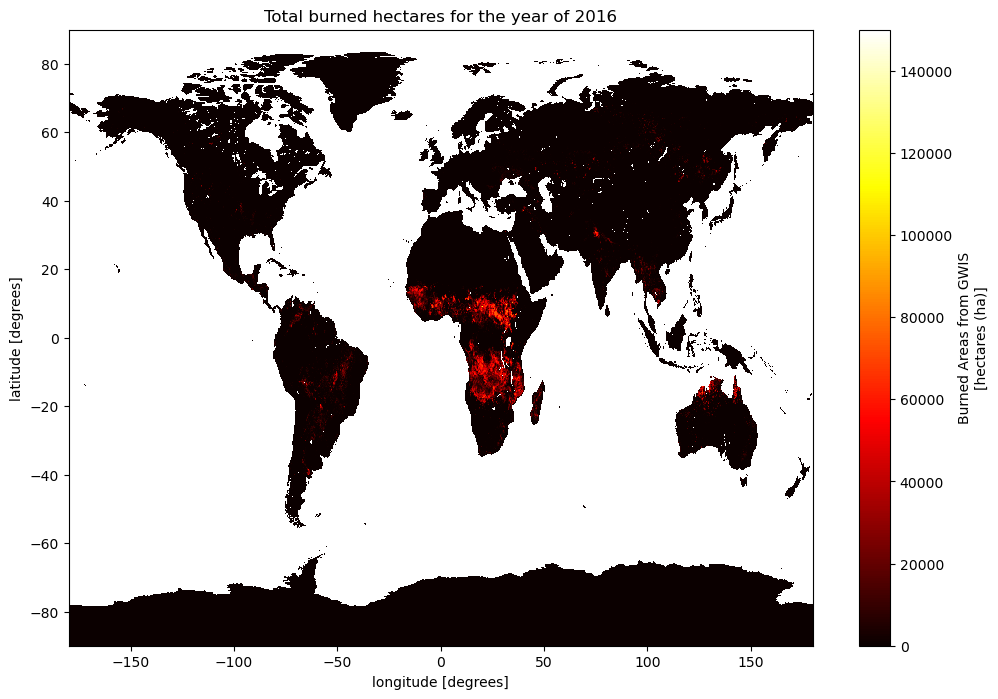

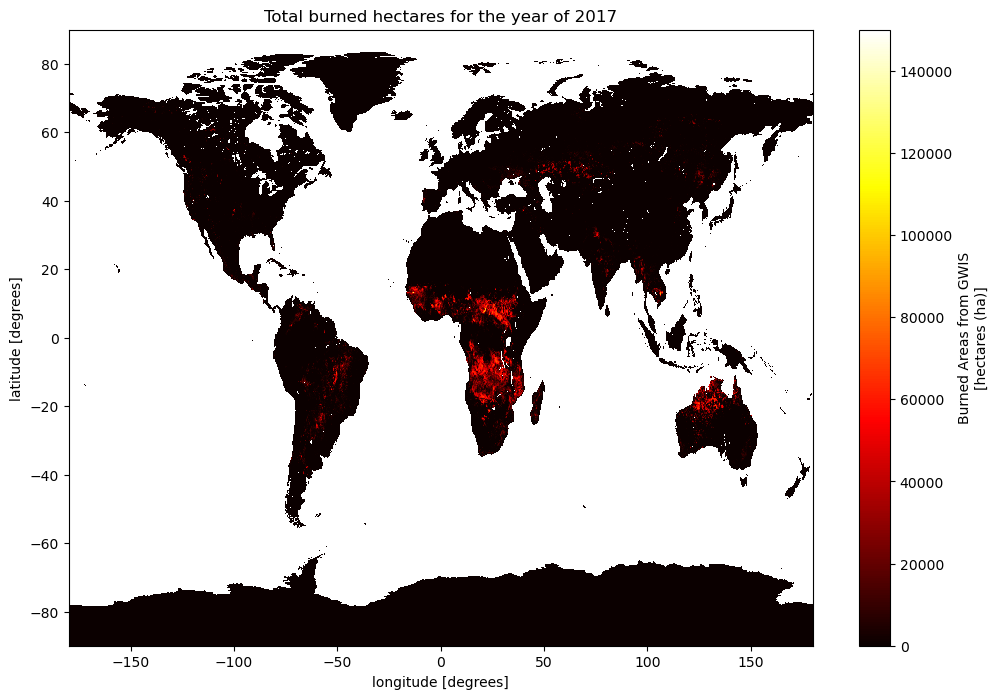

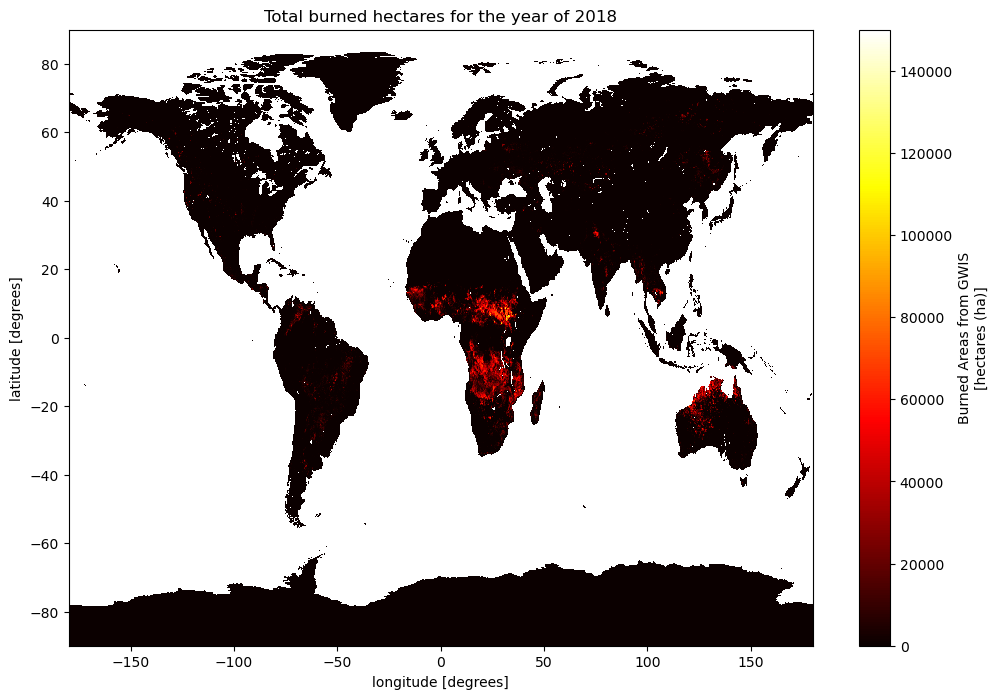

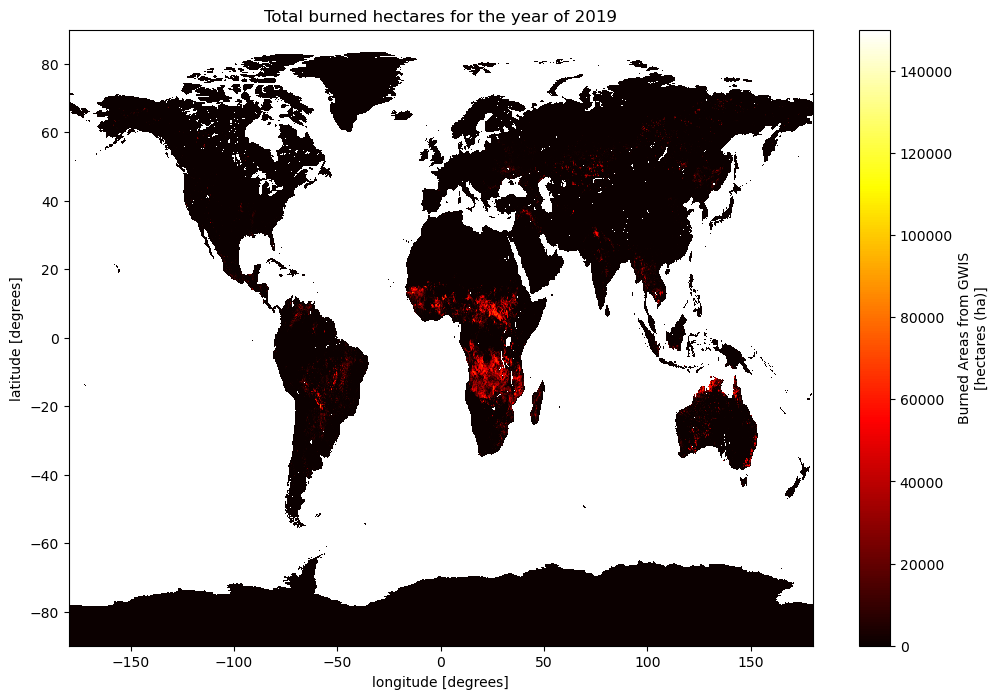

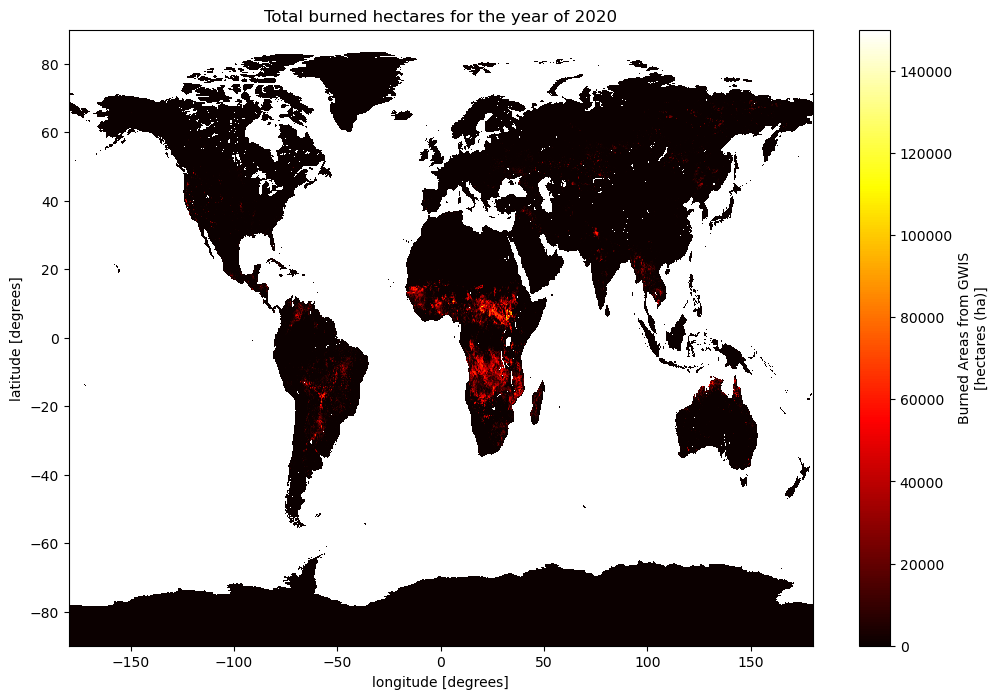

CPU times: user 2min 5s, sys: 59.1 s, total: 3min 4s
Wall time: 1min 56s


In [21]:
%%time
for i in range (20):
    figure(figsize=(12, 8))
    #cmap is for the colorbar 
    gwis_all[i,:,:].plot(vmin=0,vmax=150000,cmap='hot') #cmap="OrRd"
    plt.title('Total burned hectares for the year of '+str(i+2001))
    #plt.tight_layout()
    #this would save your images
    #you can increase the dpi for better resolution 
    plt.savefig('BAs_year_'+str(i+2001), bbox_inches='tight', dpi=200)#, quality=95)
    plt.show()

## now lets make a GIF

In [13]:
%%time
#sort the pngs
files = sorted(glob.glob("BAs*.png"))


CPU times: user 2.88 ms, sys: 0 ns, total: 2.88 ms
Wall time: 3.12 ms


In [14]:
%%time
#make sure you have the files in the correct order
files

CPU times: user 5 μs, sys: 0 ns, total: 5 μs
Wall time: 10 μs


[]

In [22]:
#if the previous doen't sort them correctly choose the following code
#You ll need the following code one of you don't have the appropiate title in your pngs 
#Sort the files by order of creation
files = glob.glob("BAs*.png")
files.sort(key=os.path.getmtime)

In [23]:
#make sure all images have the same shape and size
for i in files:
    im = Image. open(i)
    print(im. info['dpi'])
    print(im)

(199.9996, 199.9996)
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1996x1401 at 0x7F002185B4F0>
(199.9996, 199.9996)
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1996x1401 at 0x7F0021DEC2E0>
(199.9996, 199.9996)
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1996x1401 at 0x7F0021FFE1D0>
(199.9996, 199.9996)
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1996x1401 at 0x7F002240ED70>
(199.9996, 199.9996)
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1996x1401 at 0x7F0021FFE1D0>
(199.9996, 199.9996)
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1996x1401 at 0x7F002185B4F0>
(199.9996, 199.9996)
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1996x1401 at 0x7F0021FFE1D0>
(199.9996, 199.9996)
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1996x1401 at 0x7F002185AE00>
(199.9996, 199.9996)
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1996x1401 at 0x7F0021FFE1D0>
(199.9996, 199.9996)
<PIL.PngImagePlugin.PngImageFile image mode

In [24]:
#probably it would not be the same so you have to resize, make background white and save 
for i in files:
    im = Image. open(i)
    #print(im)
    #this is a size I choose you can choose a different one as well
    img_resized = im.resize((2179,1579)) 
    im = ImageOps.expand(img_resized)
    #make background white so that the titles will appear 
    fill_color=(255,255,255,255)
    background = Image.new(im.mode[:-1], im.size, fill_color)
    background.paste(im, im.split()[-1]) # omit transparency
    im = background
    #you can increase the dpi as well(300 is a very good one)
    new_img = im.save('final_'+i, dpi=(100,100))

In [25]:
#sort again 
files = sorted(glob.glob("final*.png"))

In [26]:
files

['final_BAs_year_2001.png',
 'final_BAs_year_2002.png',
 'final_BAs_year_2003.png',
 'final_BAs_year_2004.png',
 'final_BAs_year_2005.png',
 'final_BAs_year_2006.png',
 'final_BAs_year_2007.png',
 'final_BAs_year_2008.png',
 'final_BAs_year_2009.png',
 'final_BAs_year_2010.png',
 'final_BAs_year_2011.png',
 'final_BAs_year_2012.png',
 'final_BAs_year_2013.png',
 'final_BAs_year_2014.png',
 'final_BAs_year_2015.png',
 'final_BAs_year_2016.png',
 'final_BAs_year_2017.png',
 'final_BAs_year_2018.png',
 'final_BAs_year_2019.png',
 'final_BAs_year_2020.png']

In [27]:
#play with fps to make it slower or faster
images = []
for i in files:
    images.append(imageio.imread(i))
imageio.mimsave('BAs_GWIS_gif_fps09.gif', images,format='GIF', fps=0.9)

/tmp/ipykernel_1219/2412458861.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(i))
